### path stuff

In [1]:
from pathlib import Path
import sys
import os

def _ensure_repo_root_on_path(start: Path) -> Path:
    current = start.resolve()
    for candidate in [current, *current.parents]:
        if (candidate / "src").exists():
            repo_root = str(candidate)
            if repo_root not in sys.path:
                sys.path.insert(0, repo_root)
            return candidate
    raise RuntimeError("Could not locate project root containing 'src'")

REPO_ROOT = _ensure_repo_root_on_path(Path.cwd())
os.chdir(REPO_ROOT)

def from_root(relative_path: str | Path) -> Path:
    return REPO_ROOT / Path(relative_path)

print(f"repo root on sys.path: {REPO_ROOT}")
print(f"cwd set to: {Path.cwd()}")

repo root on sys.path: /mnt/c/Users/samue/SynologyDrive/CompNeuro II/Computational_Neuroscience_-25--26
cwd set to: /mnt/c/Users/samue/SynologyDrive/CompNeuro II/Computational_Neuroscience_-25--26


### imports

In [2]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch import nn
import torch
from src.models.simclr_model import downsizedSimCLR
from src.utils.model_activations import ModelActivations
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import torch.nn.functional as F

### model loading

#### loading

In [3]:
ckpt = torch.load("figures/start_20260218-174517/ckpts/simclr/best_ssl_val.pt", weights_only=False)

In [4]:
model_weights = ckpt['model']
model = downsizedSimCLR()
model.load_state_dict(model_weights)
model

downsizedSimCLR(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
    

In [5]:
for name, param in model.named_parameters():
    print(name, param.shape)

encoder.conv1.weight torch.Size([64, 3, 3, 3])
encoder.bn1.weight torch.Size([64])
encoder.bn1.bias torch.Size([64])
encoder.layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
encoder.layer1.0.bn1.weight torch.Size([64])
encoder.layer1.0.bn1.bias torch.Size([64])
encoder.layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
encoder.layer1.0.bn2.weight torch.Size([64])
encoder.layer1.0.bn2.bias torch.Size([64])
encoder.layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
encoder.layer1.1.bn1.weight torch.Size([64])
encoder.layer1.1.bn1.bias torch.Size([64])
encoder.layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
encoder.layer1.1.bn2.weight torch.Size([64])
encoder.layer1.1.bn2.bias torch.Size([64])
encoder.layer2.0.conv1.weight torch.Size([128, 64, 3, 3])
encoder.layer2.0.bn1.weight torch.Size([128])
encoder.layer2.0.bn1.bias torch.Size([128])
encoder.layer2.0.conv2.weight torch.Size([128, 128, 3, 3])
encoder.layer2.0.bn2.weight torch.Size([128])
encoder.layer2.0.bn2.bias torch.Size([128])
encode

In [6]:
cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load CIFAR-10 test set
cifar_dataset = datasets.CIFAR10(root='cifar_data', train=False, download=True, transform=cifar_transform)
cifar_loader = DataLoader(cifar_dataset, batch_size=64, shuffle=False)

#### projection head activations

In [ ]:
all_acts = []
all_labels = []

layer = "projection head"

model.eval()
with torch.no_grad():
    for images, labels in cifar_loader:
        acts = model(images).cpu().numpy()  # Forward pass to populate activations
        all_acts.append(acts)
        all_labels.append(labels.numpy())
        if len(all_acts) > 20:  # Limit to ~1280 samples for speed
            break

all_acts = np.concatenate(all_acts, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

100%|██████████| 170M/170M [00:14<00:00, 11.7MB/s] 


#### specific layer activations

In [ ]:
layer = 'encoder.layer4.1'

ma_cifar = ModelActivations(model, layers=[layer])
ma_cifar.register_hooks()

all_acts = []
all_labels = []

with torch.no_grad():
    for images, labels in cifar_loader:
        _ = model(images)
        acts = ma_cifar.fetch_activations(layer)
        acts = acts.mean(dim=(2, 3)).cpu().numpy()  # Global average pooling
        all_acts.append(acts)
        all_labels.append(labels.numpy())
        if len(all_acts) > 20:  # Limit to ~1280 samples for speed
            break

all_acts = np.concatenate(all_acts, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

Registered hook for layer: encoder.layer4.1


In [ ]:
all_acts.shape, all_labels.shape

((1344, 512), (1344,))

### analysis

#### pca

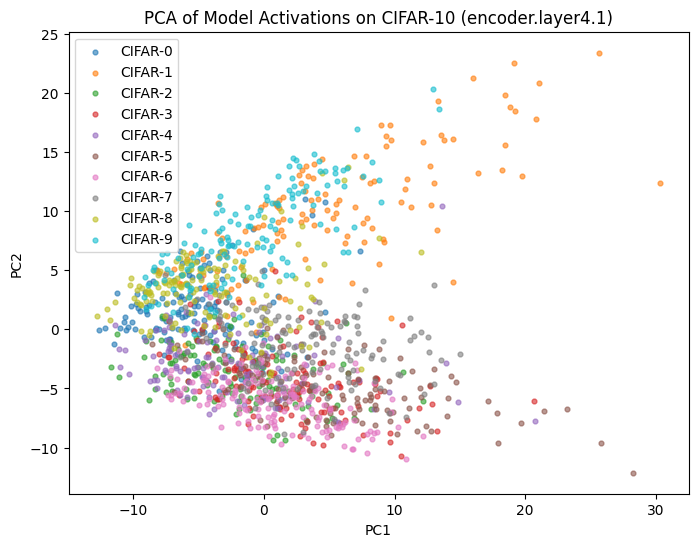

In [28]:
# PCA
pca = PCA(n_components=2)
acts_pca = pca.fit_transform(all_acts)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
for i in range(10):
    idx = all_labels == i
    plt.scatter(acts_pca[idx, 0], acts_pca[idx, 1], label=f"CIFAR-{i}", alpha=0.6, s=12)
plt.legend()
plt.title(F"PCA of Model Activations on CIFAR-10 ({layer})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

#### tsne

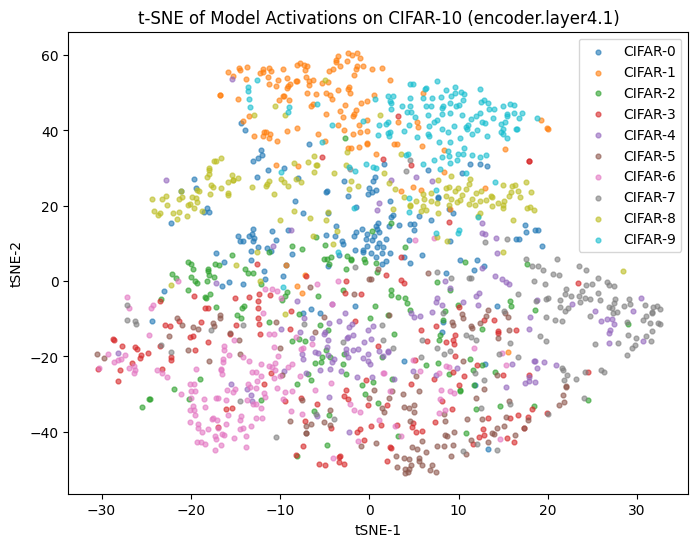

In [29]:
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto', perplexity=30)
acts_tsne = tsne.fit_transform(all_acts)

plt.figure(figsize=(8, 6))
for i in range(10):
    idx = all_labels == i
    plt.scatter(acts_tsne[idx, 0], acts_tsne[idx, 1], label=f"CIFAR-{i}", alpha=0.6, s=12)
plt.legend()
plt.title(f"t-SNE of Model Activations on CIFAR-10 ({layer})")
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.show()

### neural data

In [7]:
from src.latest_neural_data.ev_helper import forward_ev, reverse_ev
from src.latest_neural_data.model_acts import extract_model_activations_from_cache

neural_data_folder = "src/latest_neural_data/majajhong_cache/"
# neural_data_path = "src/REVERSE_PRED_FINAL/majajhong_cache/neural_activations.npy"


In [8]:
neural_activations = np.load(os.path.join(neural_data_folder, "neural_activations.npy"))

In [9]:
model_activations = np.load(os.path.join(neural_data_folder, "model_activations.npy"))

In [ ]:
layer = 'encoder.layer4.1'

model_activations, stimulus_ids = extract_model_activations_from_cache(
        model=model,
        cache_dir=neural_data_folder,#"REVERSE_PRED_FINAL/majajhong_cache"
        layer_name=layer,
        batch_size=16
    )

  Processed 80/3200 images...
  Processed 160/3200 images...
  Processed 240/3200 images...
  Processed 320/3200 images...
  Processed 400/3200 images...
  Processed 480/3200 images...
  Processed 560/3200 images...
  Processed 640/3200 images...
  Processed 720/3200 images...
  Processed 800/3200 images...
  Processed 880/3200 images...
  Processed 960/3200 images...
  Processed 1040/3200 images...
  Processed 1120/3200 images...
  Processed 1200/3200 images...
  Processed 1280/3200 images...
  Processed 1360/3200 images...
  Processed 1440/3200 images...
  Processed 1520/3200 images...
  Processed 1600/3200 images...
  Processed 1680/3200 images...
  Processed 1760/3200 images...
  Processed 1840/3200 images...
  Processed 1920/3200 images...
  Processed 2000/3200 images...
  Processed 2080/3200 images...
  Processed 2160/3200 images...
  Processed 2240/3200 images...
  Processed 2320/3200 images...
  Processed 2400/3200 images...
  Processed 2480/3200 images...
  Processed 2560/3200

In [14]:
r_ev = reverse_ev(model_activations, neural_activations, full_ev_vector=True)

/mnt/c/Users/samue/SynologyDrive/CompNeuro II/Computational_Neuroscience_-25--26/src/latest_neural_data/ev_helper.py:212: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  raw_corr = np.array([stats.pearsonr(x[:, i], y[:, i])[0] for i in range(n_neurons)])


In [19]:
# Remove NaN/Inf values from reverse EV vector
r_ev = r_ev[np.isfinite(r_ev)]
print(f"Cleaned r_ev shape: {r_ev.shape}")

Cleaned r_ev shape: (130035,)


In [20]:
r_ev.mean()

11.98492683230725

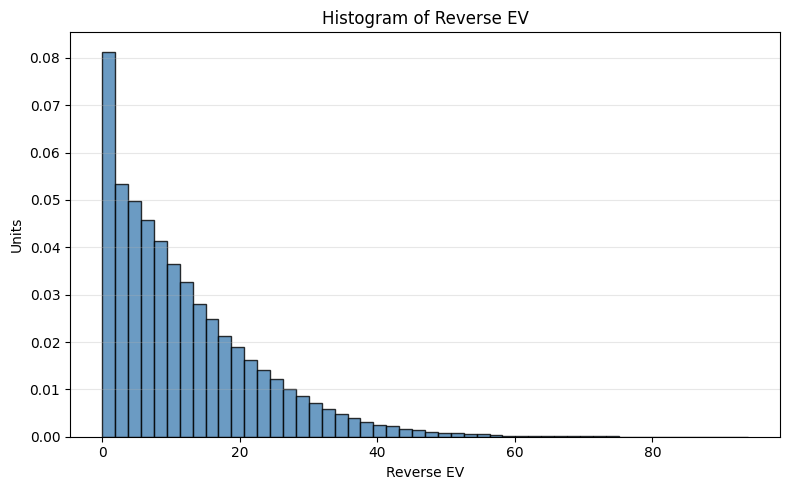

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.hist(r_ev, bins=50, color="steelblue", edgecolor="black", alpha=0.8, density=True)
plt.title("Histogram of Reverse EV")
plt.xlabel("Reverse EV")
plt.ylabel("Units")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
import matplotlib.pyplot as plt
r_ev_2 = forward_ev(neural_activations, neural_activations, full_ev_vector=True)
r_ev = r_ev_2[np.isfinite(r_ev_2)]
print(f"Cleaned r_ev shape: {r_ev.shape}")
print(r_ev.mean())

plt.figure(figsize=(8, 5))
plt.hist(r_ev, bins=50, color="steelblue", edgecolor="black", alpha=0.8, density=True)
plt.title("Histogram of Reverse EV")
plt.xlabel("Reverse EV")
plt.ylabel("Units")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

ValueError: operands could not be broadcast together with shapes (168,) (63,) 

In [1]:
f_ev = forward_ev(model_activations, neural_activations)

NameError: name 'forward_ev' is not defined

In [ ]:
bpi = 2*f_ev*r_ev/(f_ev + r_ev + 1e-12)